In [4]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [15]:
def fast_sweep_2d_numpy(grid, fixed_cells, obstacle, f, dh, iterations=5):
    # this is used for padding the outer boundaries of the domain,
    # so that the min() operations in the upwind scheme choose the inner point.
    large_val = 1e3
    ny, nx = grid.shape
    # 4 directions to sweep along - the range parameters for x and y.
    sweep_dirs = [
        (0, nx, 1, 0, ny, 1),  # Top-left to bottom-right
        (nx - 1, -1, -1, 0, ny, 1),  # Top-right to bottom-left
        (nx - 1, -1, -1, ny - 1, -1, -1),  # Bottom-right to top-left
        (0, nx, 1, ny - 1, -1, -1),  # Bottom-left to top-right
    ]

    # pad with a large value to properly handle boundary conditions in the upwind scheme.
    padded = np.pad(grid, pad_width=1, mode="constant", constant_values=large_val)

    for _ in range(iterations):
        for x_start, x_end, x_step, y_start, y_end, y_step in sweep_dirs:
            for iy in range(y_start, y_end, y_step):
                for ix in range(x_start, x_end, x_step):
                    # dont do anything for fixed cells (interface) or obstacles
                    if fixed_cells[iy, ix] or obstacle[iy, ix]:
                        continue
                    # calculate a,b from eqn 2.3 of Zhao et.al
                    py, px = iy + 1, ix + 1
                    # since it's a padded array and boundary+1 is a large value,
                    # it will choose the interior value at the end, acting like one sided difference.
                    a = np.min((padded[py, px - 1], padded[py, px + 1]))
                    b = np.min((padded[py - 1, px], padded[py + 1, px]))
                    # explicit unique solution to eq 2.3, given by eq 2.4
                    xbar = (
                        large_val  # xbar will be the distance to this cell from front
                    )
                    if np.abs(a - b) >= f * dh:
                        xbar = np.min((a, b)) + f * dh
                    else:
                        # can add small eps to sqrt later for stability
                        xbar = (a + b + np.sqrt(2 * (f * dh) ** 2 - (a - b) ** 2)) / 2
                    # update if new distance is smaller
                    padded[py, px] = np.min((padded[py, px], xbar))
    # return un-padded array
    return padded[1:-1, 1:-1]

In [21]:
@partial(jax.jit, static_argnames=["iterations"])
def fast_sweep_2d_jax(grid, fixed_cells, obstacle, f, dh, iterations=5):
    large_val = 1e3
    ny, nx = grid.shape
    sweep_dirs = [
        (0, nx, 1, 0, ny, 1),  # Top-left to bottom-right
        (nx - 1, -1, -1, 0, ny, 1),  # Top-right to bottom-left
        (nx - 1, -1, -1, ny - 1, -1, -1),  # Bottom-right to top-left
        (0, nx, 1, ny - 1, -1, -1),  # Bottom-left to top-right
    ]
    frozen = jnp.logical_or(fixed_cells, obstacle)
    padded = jnp.pad(grid, pad_width=1, mode="constant", constant_values=large_val)

    def run_sweep(sweep_dir, grid):
        x_start, x_end, x_step, y_start, y_end, y_step = sweep_dir

        def y_loop_body(iy, grid):
            def x_loop_body(ix, grid):
                piy, pix = iy + 1, ix + 1
                a = jnp.minimum(grid[piy, pix - 1], grid[piy, pix + 1])
                b = jnp.minimum(grid[piy - 1, pix], grid[piy + 1, pix])
                updated_val = jnp.where(
                    frozen[iy, ix],
                    grid[piy, pix],  # no change if frozen
                    jnp.minimum(  # min of curr and updated val
                        grid[piy, pix],
                        jnp.where(  # eqn 2.4
                            jnp.abs(a - b) >= f * dh,
                            jnp.minimum(a, b) + f * dh,
                            (a + b + jnp.sqrt(2 * (f * dh) ** 2 - (a - b) ** 2)) / 2,
                        ),
                    ),
                )
                return grid.at[piy, pix].set(updated_val)

            x_indices = jnp.arange(x_start, x_end, x_step)
            return jax.lax.fori_loop(
                0,
                len(x_indices),
                # ix is 0..len(x_indices) - we need to map it to actual range
                lambda ix, grid: x_loop_body(x_indices[ix], grid),
                grid,
            )

        y_indices = jnp.arange(y_start, y_end, y_step)
        return jax.lax.fori_loop(
            0,
            len(y_indices),
            lambda iy, grid: y_loop_body(y_indices[iy], grid),
            grid,
        )

    def iteration_body(_, cur_grid):
        # perform 4 sweeps (2 dimentions)
        grid_s1 = run_sweep(sweep_dirs[0], cur_grid)
        grid_s2 = run_sweep(sweep_dirs[1], grid_s1)
        grid_s3 = run_sweep(sweep_dirs[2], grid_s2)
        grid_s4 = run_sweep(sweep_dirs[3], grid_s3)
        return grid_s4

    final_grid = jax.lax.fori_loop(0, iterations, iteration_body, padded)
    return final_grid[1:-1, 1:-1]

# Execution example


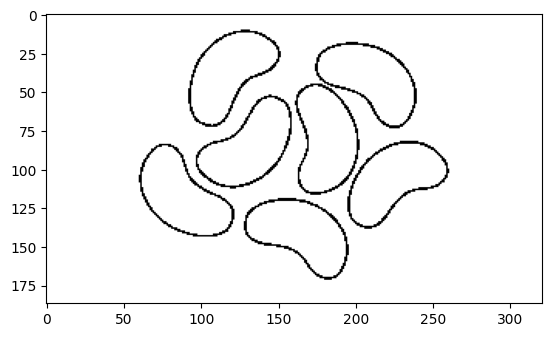

In [7]:
img = np.array(Image.open("./data/processed_beans.png"))
plt.imshow(img, cmap="grey")

In [35]:
ny, nx = img.shape

# print(ny, nx)
X_np, Y_np = np.meshgrid(
    np.arange(0, nx),
    np.arange(0, ny),
)
dx = X_np[0, 1] - X_np[0, 0]
# dx=dy
dh = dx  # dh is grid spacing
interface_mask = img == 0
obstacle_mask = np.zeros_like(X_np)
# obstacle_mask[(X_np >= 50) & (X_np <= 55) & (Y_np >= 100) & (Y_np <= 125)] = 1
obstacle_mask[(X_np >= 50) & (X_np <= 55) & (Y_np >= 100)] = 1


dist_grid_np = np.ones_like(X_np) * 100.0  # set far away cells to be a large value
dist_grid_np[interface_mask] = 0.0


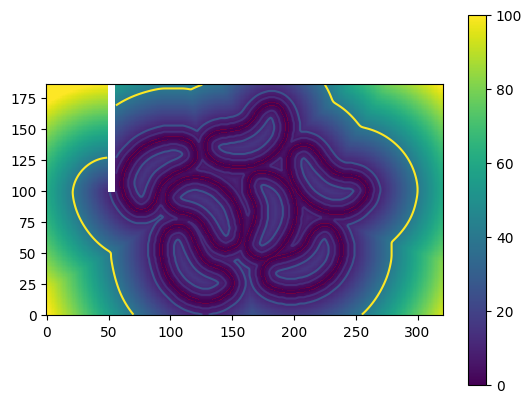

In [33]:
out = fast_sweep_2d_numpy(
    dist_grid_np, interface_mask, obstacle_mask, f=1, dh=dh, iterations=5
)
out[obstacle_mask.astype(bool)] = np.nan

plt.pcolormesh(X_np, Y_np, out)
plt.colorbar()
plt.contour(X_np, Y_np, out, levels=[0], colors="red")
plt.contour(X_np, Y_np, out, levels=[0, 5, 10, 40])
plt.gca().set_aspect(1)

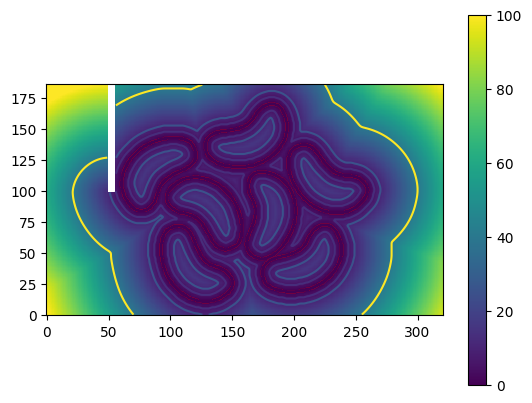

In [38]:
out = fast_sweep_2d_jax(
    jnp.array(dist_grid_np),
    jnp.array(interface_mask),
    jnp.array(obstacle_mask),
    f=1,
    dh=dh,
    iterations=5,
)
out = np.array(out)
out[obstacle_mask.astype(bool)] = np.nan

plt.pcolormesh(X_np, Y_np, out)
plt.colorbar()
plt.contour(X_np, Y_np, out, levels=[0], colors="red")
plt.contour(X_np, Y_np, out, levels=[0, 5, 10, 40])
plt.gca().set_aspect(1)